In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [2]:
import pandas as pd
import numpy as np
import keras
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping

import sklearn.metrics as metrics
from keras.callbacks import LearningRateScheduler
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

In [3]:
import os
import pandas as pd

MildDemented_dir = r'/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset/MildDemented'
ModerateDemented_dir = r'/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset/ModerateDemented'
NonDemented_dir = r'/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset/NonDemented'
VeryMildDemented_dir = r'/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset/VeryMildDemented'

filepaths = []
labels = []
dict_list = [MildDemented_dir, ModerateDemented_dir, NonDemented_dir, VeryMildDemented_dir]
class_labels = ['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very MildDemented']
for i, j in enumerate(dict_list):
    flist = os.listdir(j)
    for f in flist:
        fpath = os.path.join(j, f)
        filepaths.append(fpath)
        labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
Alzheimer_data = pd.concat([Fseries, Lseries], axis=1)
Alzheimer_df = pd.DataFrame(Alzheimer_data)
print(Alzheimer_df.head())
print(Alzheimer_df["labels"].value_counts())

                                           filepaths         labels
0  /kaggle/input/augmented-alzheimer-mri-dataset/...  Mild Demented
1  /kaggle/input/augmented-alzheimer-mri-dataset/...  Mild Demented
2  /kaggle/input/augmented-alzheimer-mri-dataset/...  Mild Demented
3  /kaggle/input/augmented-alzheimer-mri-dataset/...  Mild Demented
4  /kaggle/input/augmented-alzheimer-mri-dataset/...  Mild Demented
labels
Non Demented         9600
Mild Demented        8960
Very MildDemented    8960
Moderate Demented    6464
Name: count, dtype: int64


In [4]:
Alzheimer_df.shape

(33984, 2)

In [5]:
train_images, test_images = train_test_split(Alzheimer_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(Alzheimer_df, test_size=0.2, random_state=42)

In [6]:
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(27187, 2)
(10196, 2)
(6797, 2)
(23788, 2)


In [7]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",y_col="labels",
                                      target_size=(244,244),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=32,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=32,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=32,
                                    shuffle=False
                                   )

Found 27187 validated image filenames belonging to 4 classes.
Found 10196 validated image filenames belonging to 4 classes.
Found 6797 validated image filenames belonging to 4 classes.


In [8]:
classes=list(train.class_indices.keys())
print (classes)

['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very MildDemented']


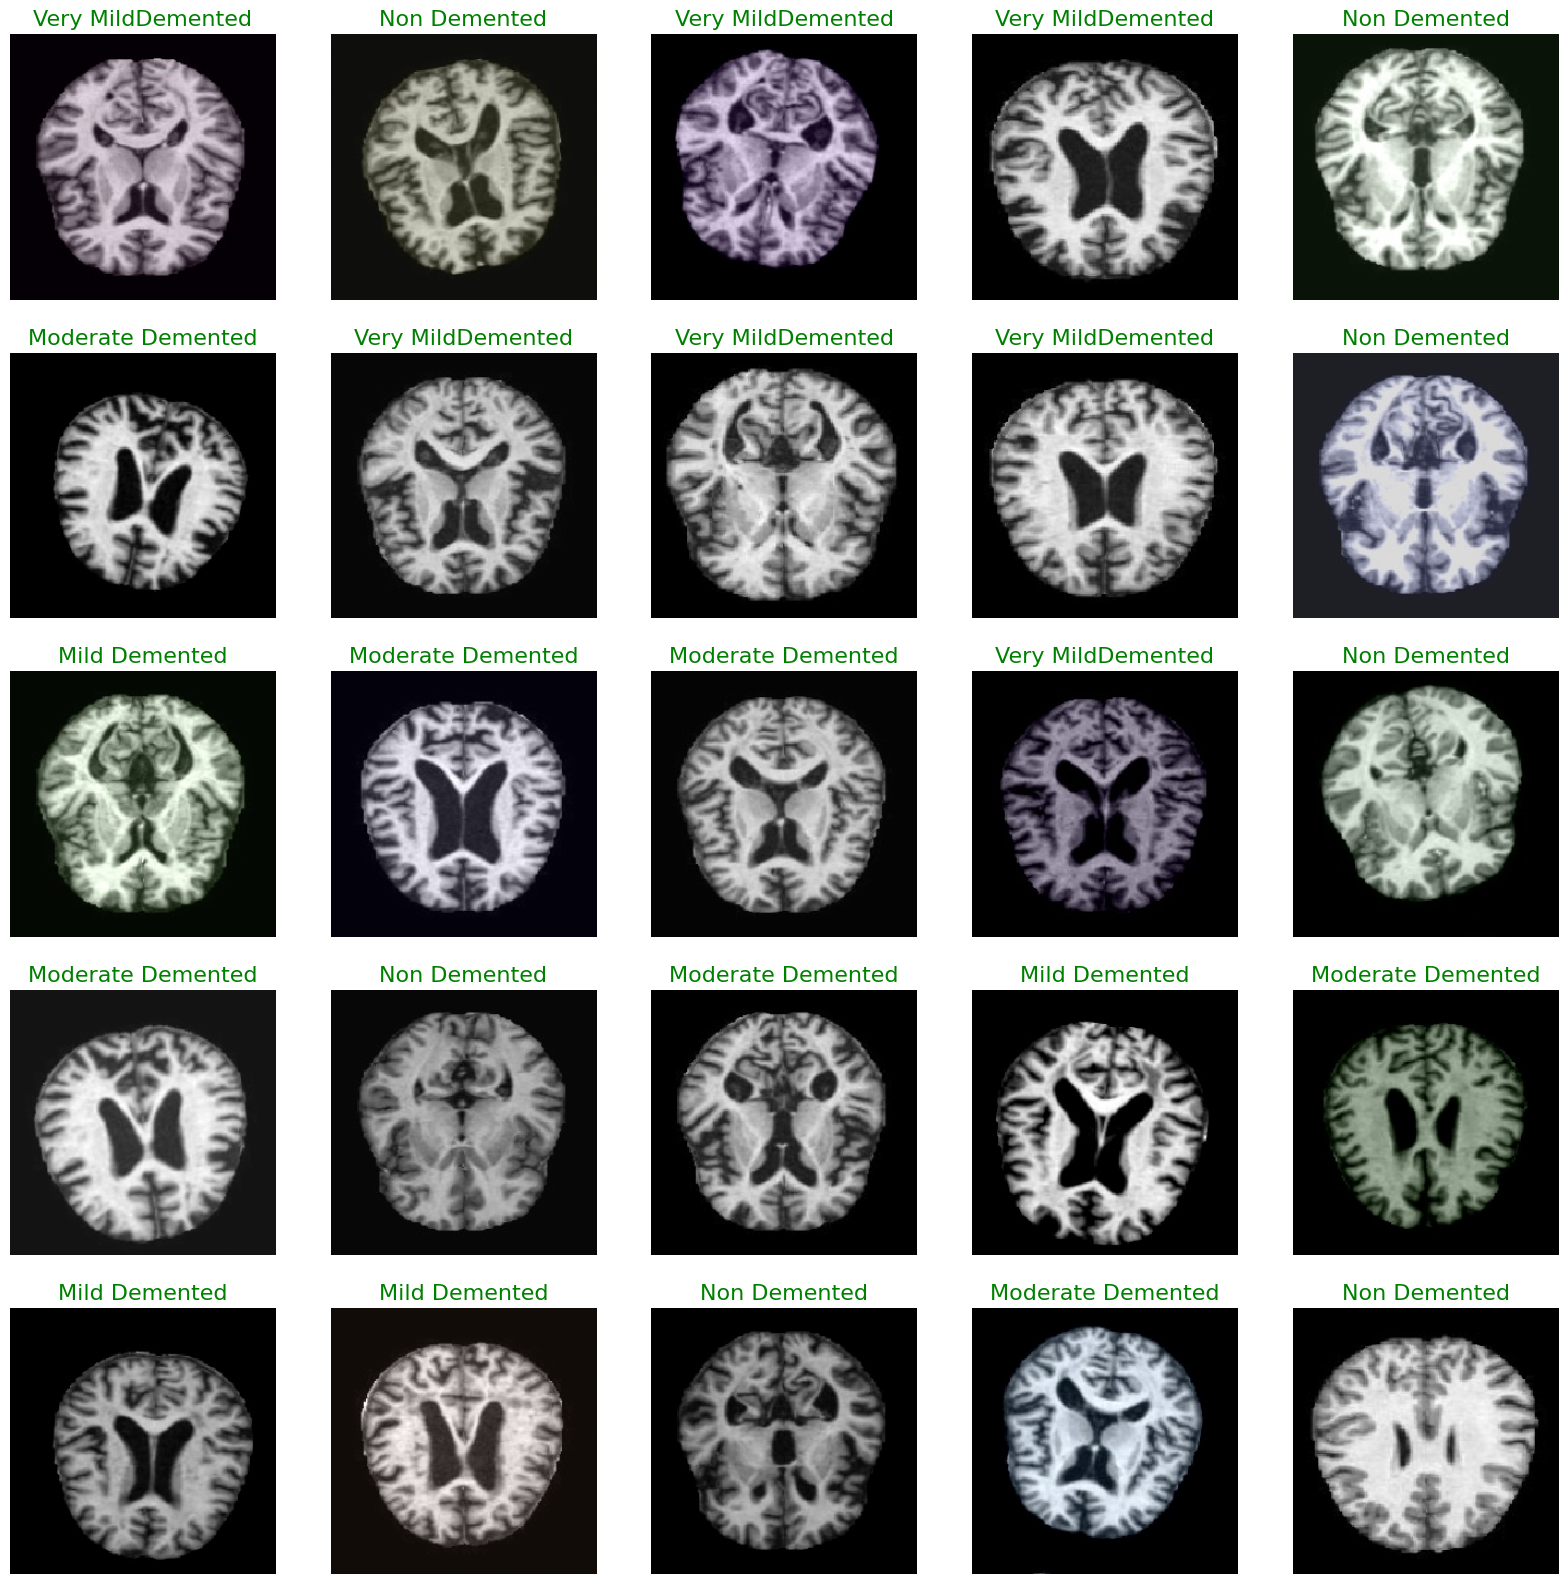

In [9]:
def show_knee_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()
show_knee_images(train)

In [10]:
from tensorflow.keras.optimizers import Adamax

img_shape = (244, 244, 3)
base_model = tf.keras.applications.DenseNet121(include_top=False, weights="imagenet",
                                               input_shape=img_shape, pooling='max')

# for layer in base_model.layers:
#     layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate=0.3),
    Dense(128, activation='relu'),
    Dropout(rate=0.25),
    Dense(4, activation='softmax')
])

model.compile(Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ ?                      │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 6,953,856 (26.53 MB)

 Non-trainable params: 83,648 (326.75 KB)

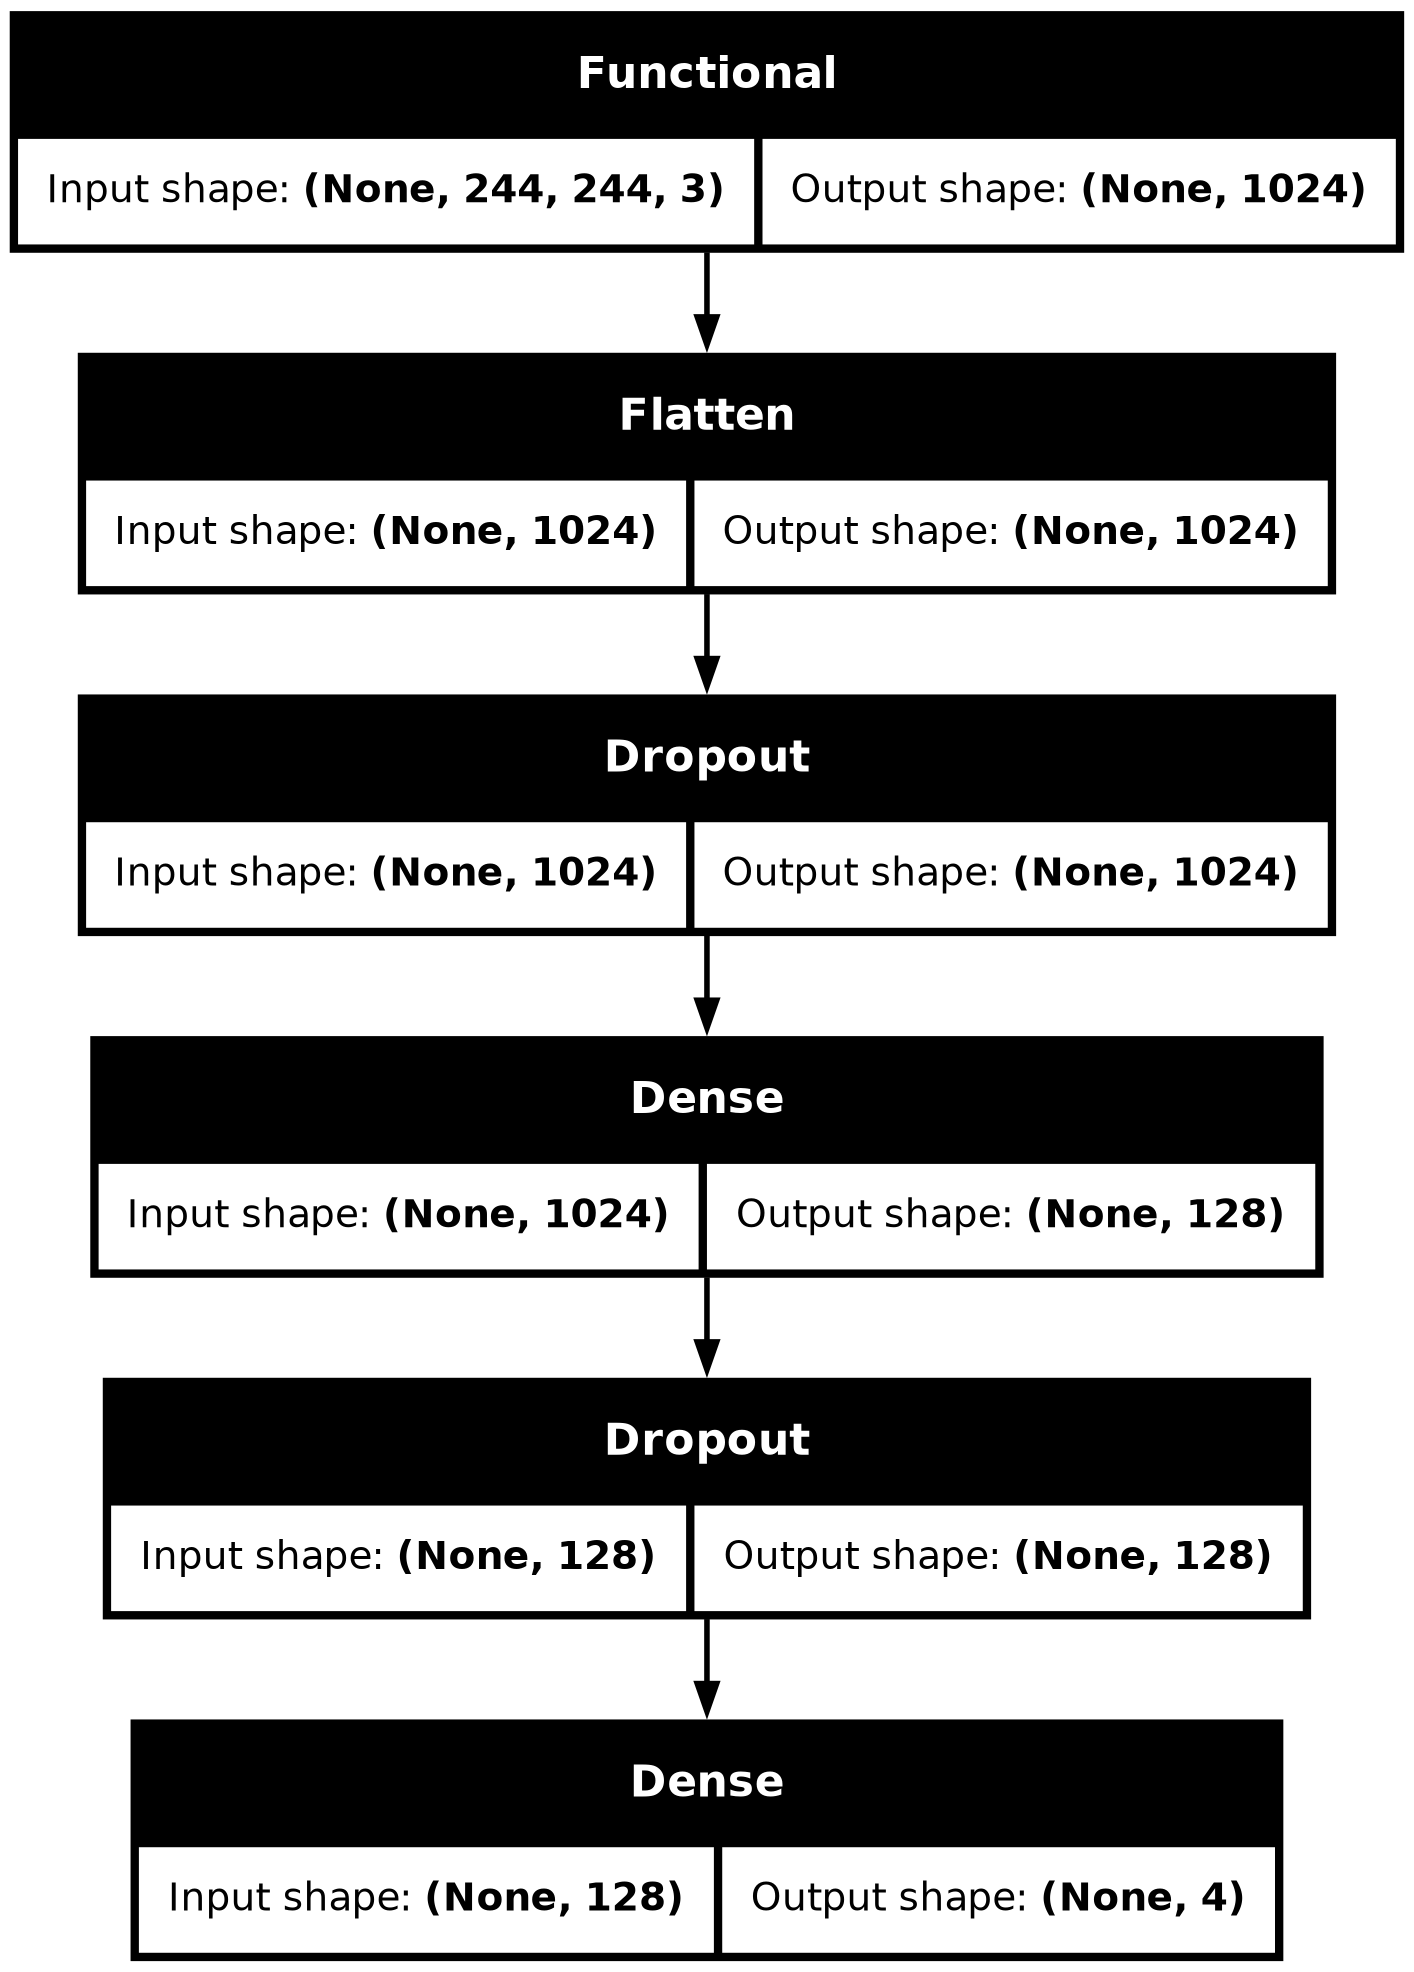

In [11]:
model.build(input_shape=(None, *img_shape))
tf.keras.utils.plot_model(model, show_shapes=True)

In [12]:
history = model.fit(train, epochs=10, validation_data=val, validation_freq=1)

Epoch 1/10


I0000 00:00:1733673073.286544     136 service.cc:145] XLA service 0x79ffe4004df0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733673073.286628     136 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1733673162.843077     136 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_slice_fusion_2', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1733673163.026985     136 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


850/850 ━━━━━━━━━━━━━━━━━━━━ 465s 384ms/step - accuracy: 0.5645 - loss: 1.2693 - val_accuracy: 0.7864 - val_loss: 0.4680
Epoch 2/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 198s 232ms/step - accuracy: 0.8424 - loss: 0.3748 - val_accuracy: 0.7241 - val_loss: 0.7552
Epoch 3/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 196s 230ms/step - accuracy: 0.9251 - loss: 0.2059 - val_accuracy: 0.8545 - val_loss: 0.4094
Epoch 4/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 195s 229ms/step - accuracy: 0.9597 - loss: 0.1200 - val_accuracy: 0.9532 - val_loss: 0.1314
Epoch 5/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 196s 230ms/step - accuracy: 0.9762 - loss: 0.0712 - val_accuracy: 0.9585 - val_loss: 0.1098
Epoch 6/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 195s 229ms/step - accuracy: 0.9854 - loss: 0.0440 - val_accuracy: 0.9819 - val_loss: 0.0521
Epoch 7/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 196s 230ms/step - accuracy: 0.9896 - loss: 0.0345 - val_accuracy: 0.9370 - val_loss: 0.2366
Epoch 8/10
850/850 ━━━━━━━━━━━━━━━━━━━━ 194s 228ms/step - accuracy: 0.9900 - loss: 0.03

In [13]:
model.evaluate(test, verbose=1)

319/319 ━━━━━━━━━━━━━━━━━━━━ 33s 105ms/step - accuracy: 0.9872 - loss: 0.0376


[0.03067239373922348, 0.9891133904457092]

In [14]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

319/319 ━━━━━━━━━━━━━━━━━━━━ 37s 91ms/step


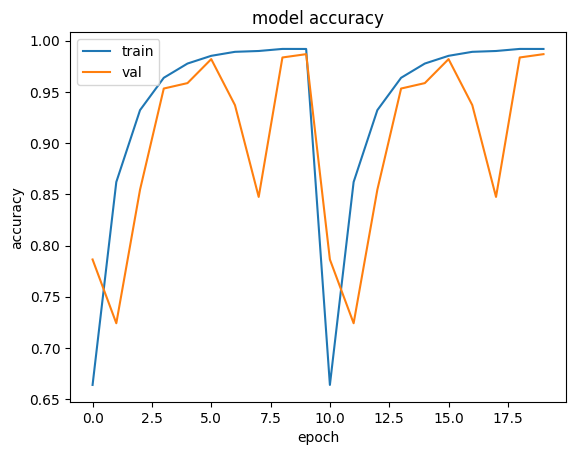

In [16]:
plt.plot(history.history['accuracy'] + history.history['accuracy'])
plt.plot(history.history['val_accuracy'] + history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

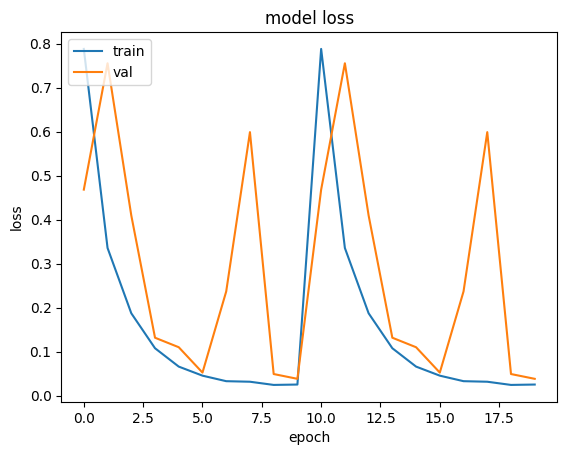

In [18]:
plt.plot(history.history['loss'] + history.history['loss'])
plt.plot(history.history['val_loss'] + history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [28]:
history1 = model.fit(train, epochs=2, validation_data=val, validation_freq=1)

Epoch 1/2
850/850 ━━━━━━━━━━━━━━━━━━━━ 197s 231ms/step - accuracy: 0.9973 - loss: 0.0086 - val_accuracy: 0.9954 - val_loss: 0.0136
Epoch 2/2
850/850 ━━━━━━━━━━━━━━━━━━━━ 197s 231ms/step - accuracy: 0.9983 - loss: 0.0050 - val_accuracy: 0.9896 - val_loss: 0.0342


In [29]:
model.evaluate(test, verbose=1)

319/319 ━━━━━━━━━━━━━━━━━━━━ 24s 75ms/step - accuracy: 0.9901 - loss: 0.0322


[0.025141563266515732, 0.9920557141304016]

In [30]:
pred = model.predict(test)
pred = np.argmax(pred, axis=1) #pick class with highest  probability

labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

319/319 ━━━━━━━━━━━━━━━━━━━━ 22s 69ms/step


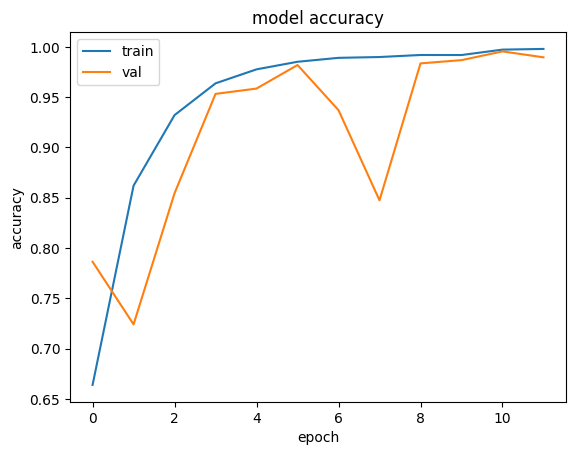

In [31]:
plt.plot(history.history['accuracy'] + history1.history['accuracy'])
plt.plot(history.history['val_accuracy'] + history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

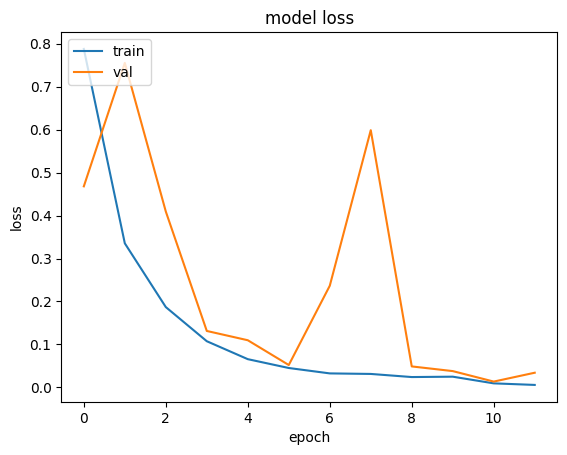

In [32]:
plt.plot(history.history['loss'] + history1.history['loss'])
plt.plot(history.history['val_loss'] + history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [33]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_test = test_images.labels # set y_test to the expected output
print(classification_report(y_test, pred2))
print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred2)*100))

                   precision    recall  f1-score   support

    Mild Demented       1.00      0.99      0.99      2693
Moderate Demented       1.00      1.00      1.00      1977
     Non Demented       0.98      1.00      0.99      2811
Very MildDemented       0.99      0.98      0.99      2715

         accuracy                           0.99     10196
        macro avg       0.99      0.99      0.99     10196
     weighted avg       0.99      0.99      0.99     10196

Accuracy of the Model: 99.2%


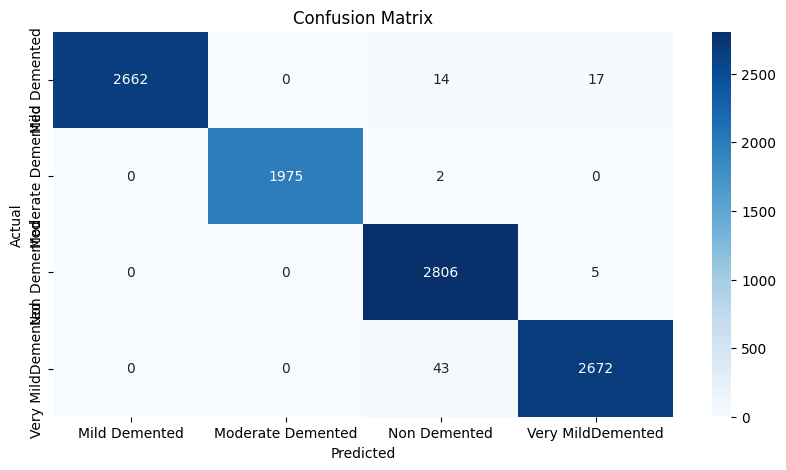

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the class labels
class_labels = ['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very MildDemented']

# Calculate the confusion matrix
cm = confusion_matrix(y_test, pred2)

# Create a figure and plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

# Set tick labels and axis labels
plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5], labels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Set the title
plt.title("Confusion Matrix")

# Show the plot
plt.show()


In [36]:
model.save('alzheimer_densenet121.h5')

In [37]:
# Load the saved model
from tensorflow.keras.models import load_model

loaded_model = load_model("alzheimer_densenet121.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


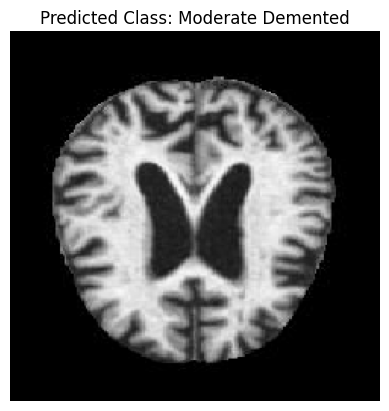

In [39]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Define the class names
class_names = ['Mild Demented', 'Moderate Demented', 'Non-Demented', 'Very Mild Demented'] 

# Path to the new image
image_path = "/kaggle/input/augmented-alzheimer-mri-dataset/OriginalDataset/ModerateDemented/30 (2).jpg"  # Replace with your image path

# Load and preprocess the image
img = image.load_img(image_path, target_size=(244, 244))  # Change target size to (244, 244)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize as done during training

# Predict the class
predictions = loaded_model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)[0]

# Get the class name using the index
predicted_class_name = class_names[predicted_class]

# Display the image and predicted class name
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted Class: {predicted_class_name}")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


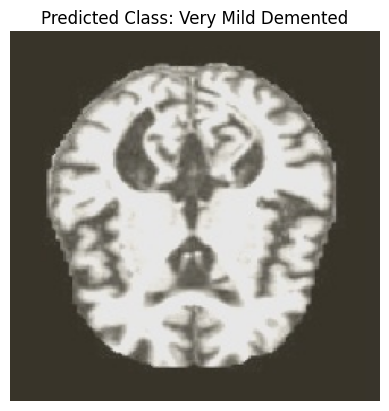

In [40]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Define the class names
class_names = ['Mild Demented', 'Moderate Demented', 'Non-Demented', 'Very Mild Demented'] 

# Path to the new image
image_path = "/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset/VeryMildDemented/002149f6-8f25-4b27-9d7a-d059f3966676.jpg"  # Replace with your image path

# Load and preprocess the image
img = image.load_img(image_path, target_size=(244, 244))  # Change target size to (244, 244)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize as done during training

# Predict the class
predictions = loaded_model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)[0]

# Get the class name using the index
predicted_class_name = class_names[predicted_class]

# Display the image and predicted class name
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted Class: {predicted_class_name}")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


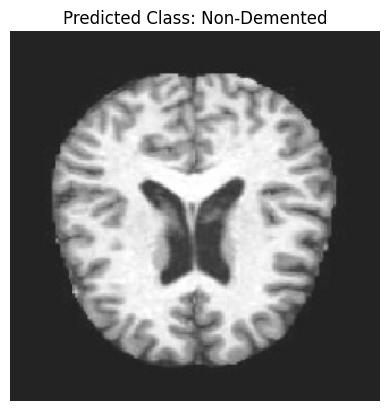

In [41]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Define the class names
class_names = ['Mild Demented', 'Moderate Demented', 'Non-Demented', 'Very Mild Demented'] 

# Path to the new image
image_path = "/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset/NonDemented/00a98422-8b63-47e6-8b8f-9119984d87ee.jpg"  # Replace with your image path

# Load and preprocess the image
img = image.load_img(image_path, target_size=(244, 244))  # Change target size to (244, 244)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize as done during training

# Predict the class
predictions = loaded_model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)[0]

# Get the class name using the index
predicted_class_name = class_names[predicted_class]

# Display the image and predicted class name
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted Class: {predicted_class_name}")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


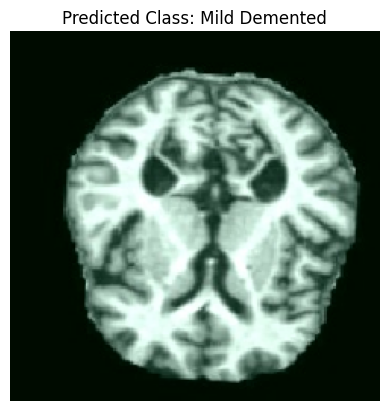

In [42]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Define the class names
class_names = ['Mild Demented', 'Moderate Demented', 'Non-Demented', 'Very Mild Demented'] 

# Path to the new image
image_path = "/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset/MildDemented/00ddce1c-fd19-4925-9fa6-addc480a012c.jpg"  # Replace with your image path

# Load and preprocess the image
img = image.load_img(image_path, target_size=(244, 244))  # Change target size to (244, 244)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize as done during training

# Predict the class
predictions = loaded_model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)[0]

# Get the class name using the index
predicted_class_name = class_names[predicted_class]

# Display the image and predicted class name
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted Class: {predicted_class_name}")
plt.show()
